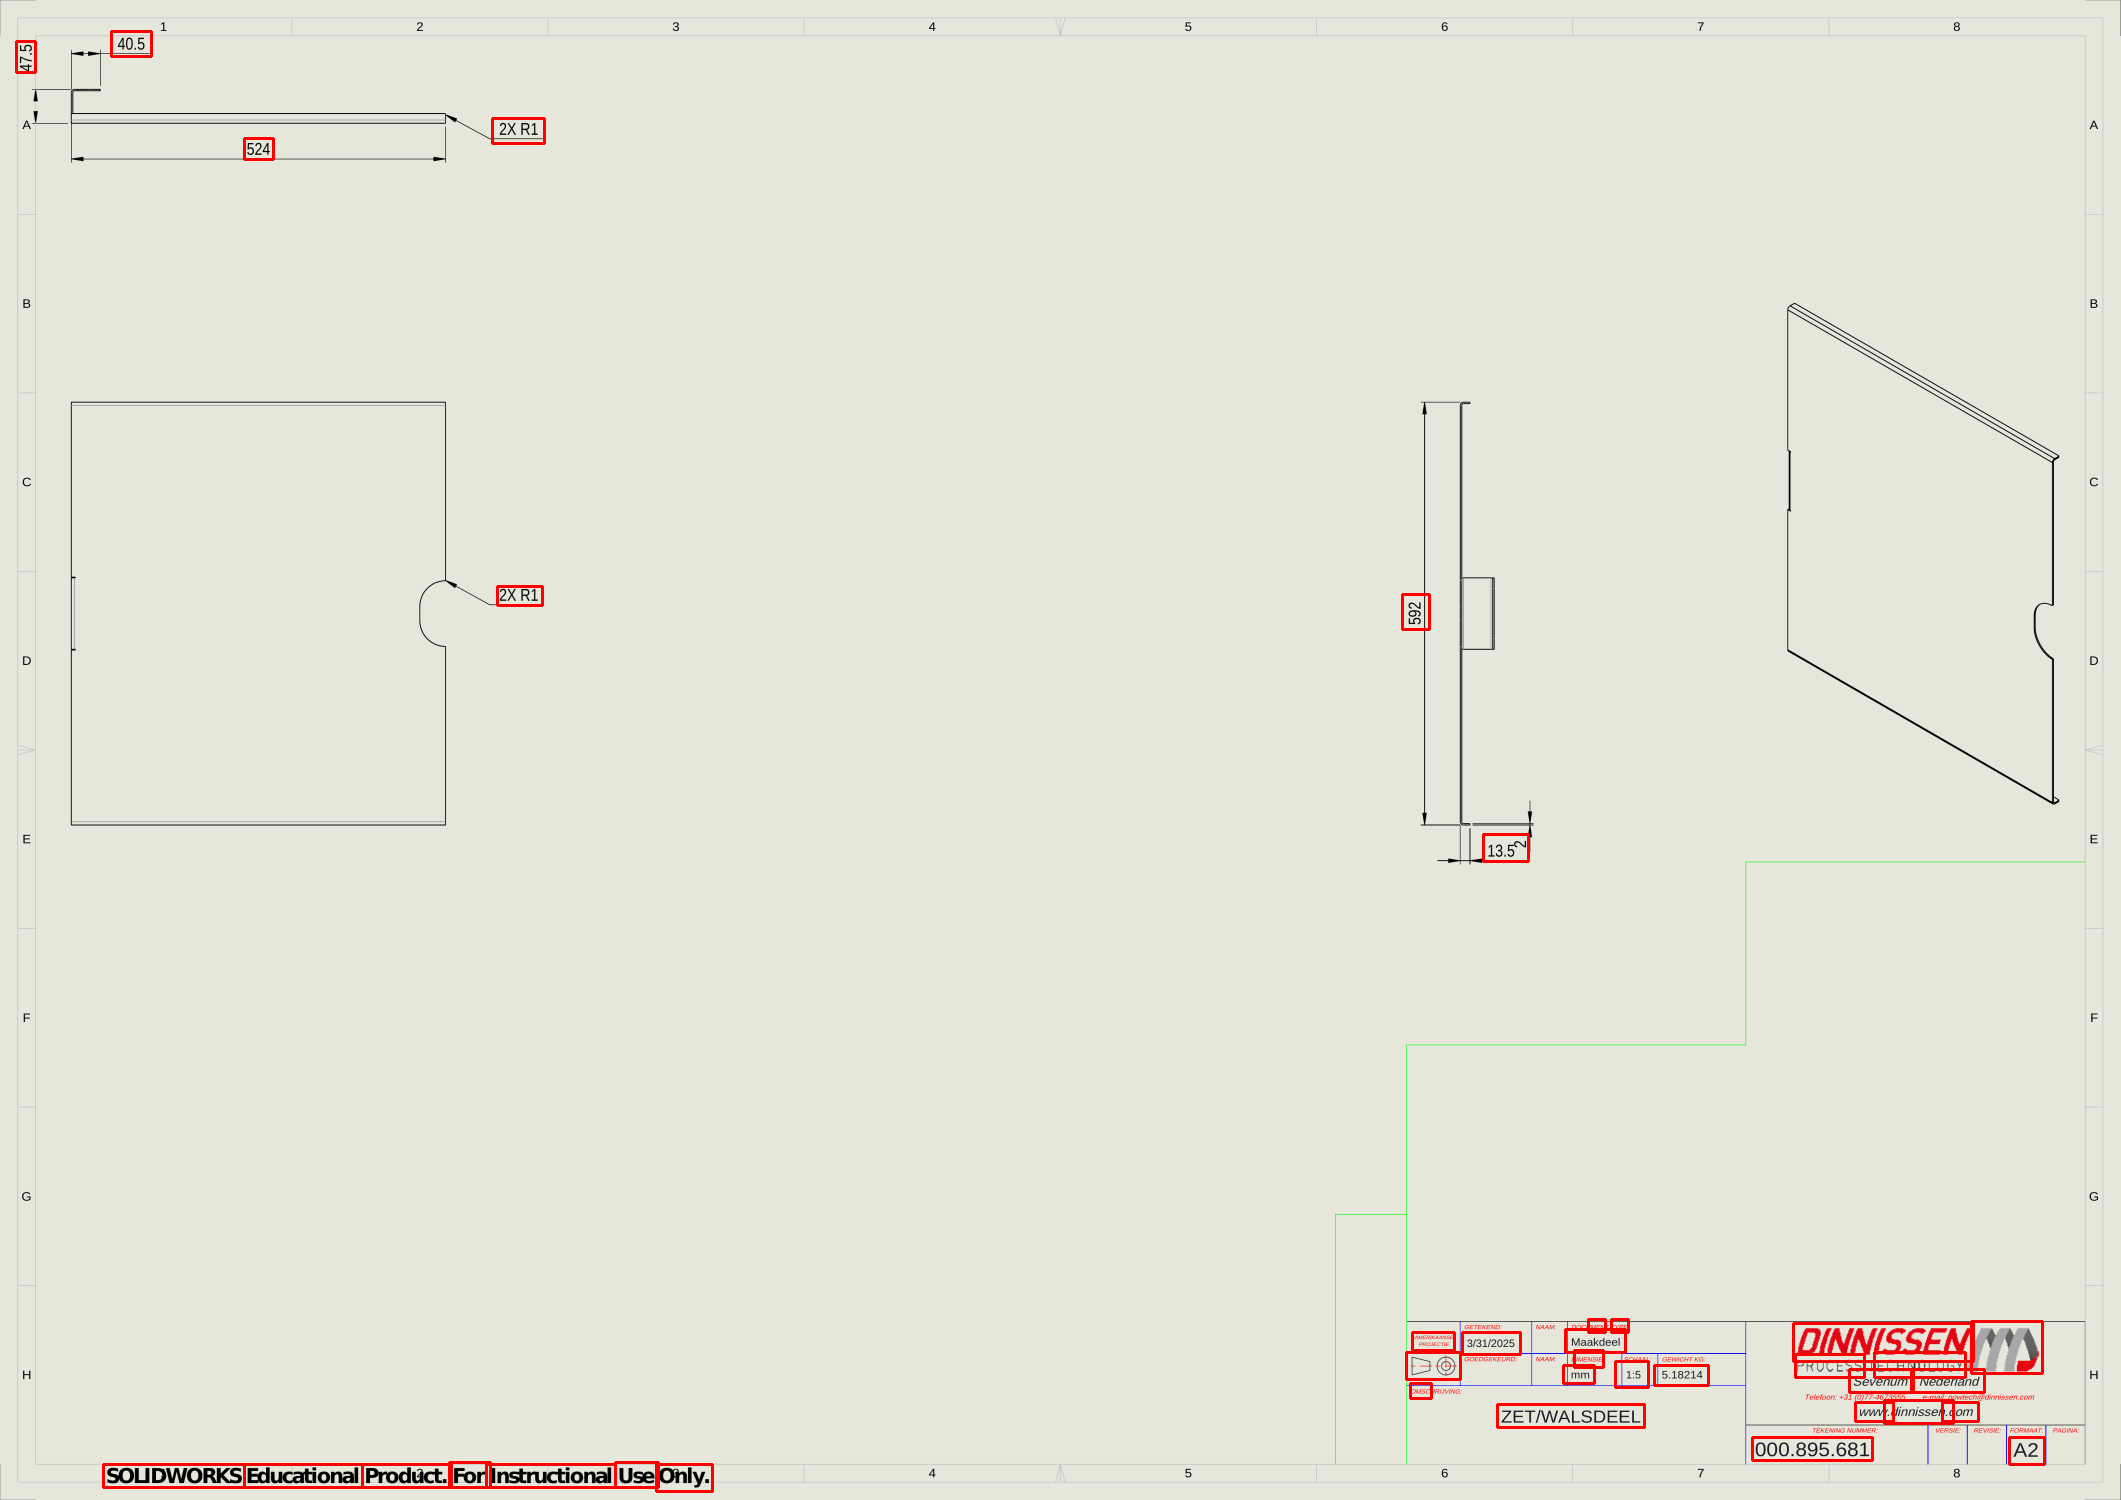

In [1]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *
from template_extraction import *


# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/3.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Good/300-014823.pdf"
# f = "../../data/original/Good/300-014822.pdf"
# f = "../../data/original/Ugly/000.001.373.pdf"
# f = "../../data/original/Good/15316-100-D-020_Sheet2.pdf"
f = "../../data/original/Ugly/000.895.681.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

im_h, im_w, _ = img.shape
sorted_indices, contours, hierarchy_area = detect_objects(img)
title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
ocr_result = data["ocr_result"]
mask = data["mask"]
inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
words = process_text(ocr_result, im_h, im_w)

border_1, border_2 = detect_borders(contours, sorted_indices, words)
contours = detect_text_tables(img, words, mask)
title_contours = title_contours + contours

boundary = get_boundary(border_1, border_2, inner_border_lines)

for idx, row in words.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

Image.fromarray(img_comp)

2


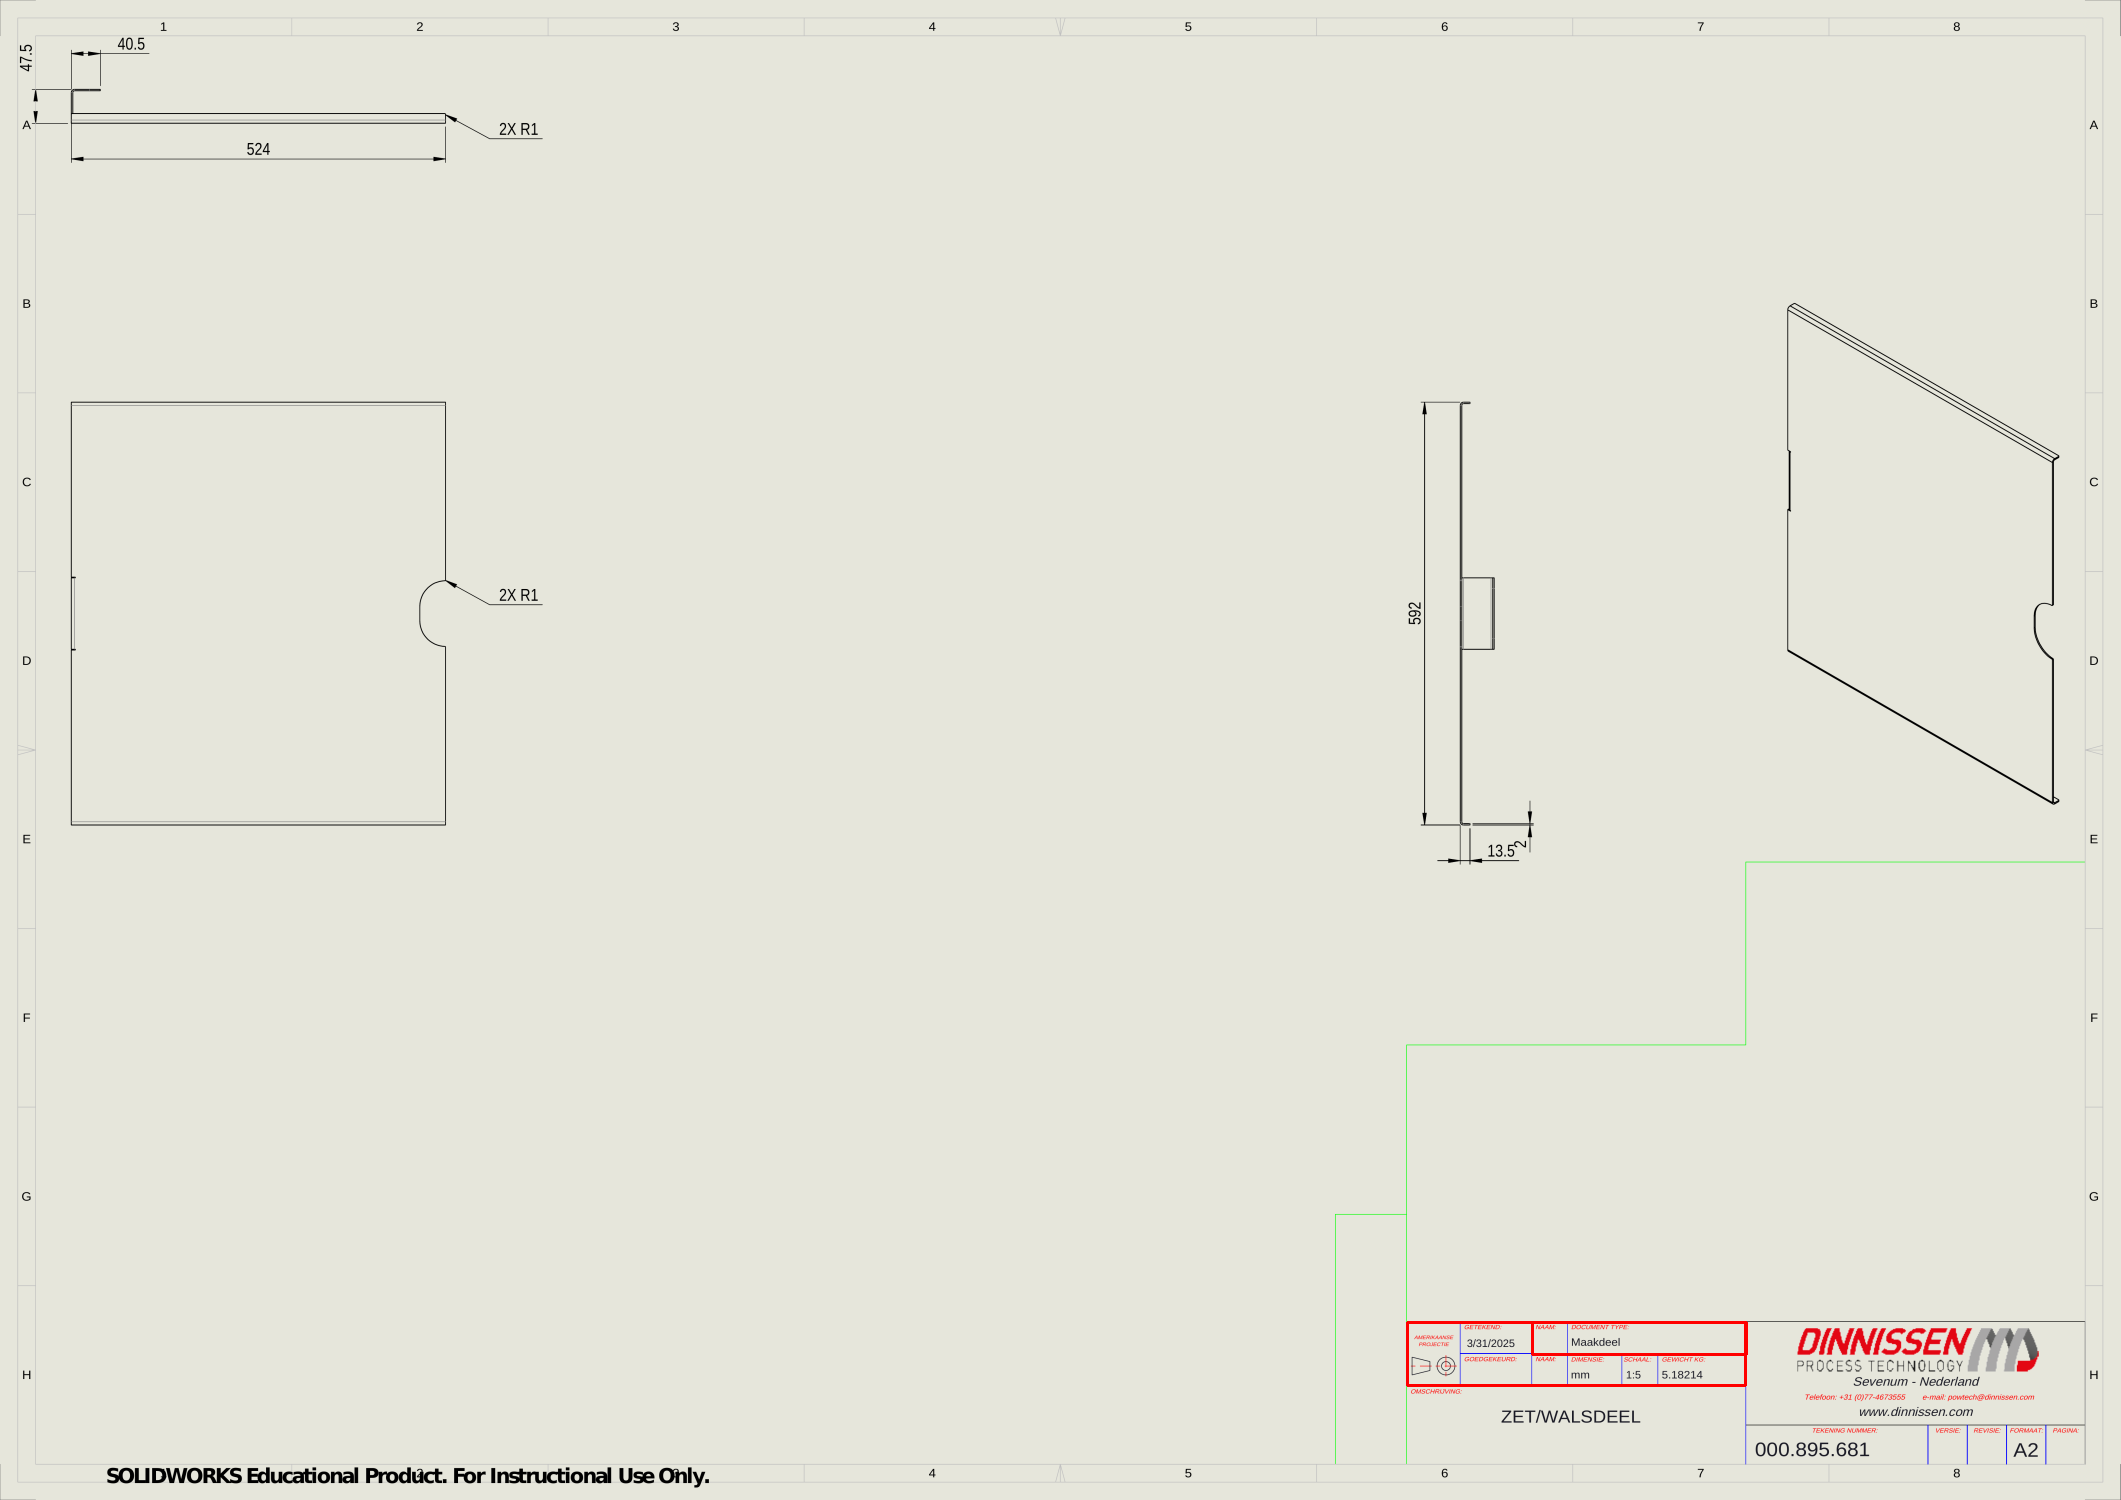

In [2]:
tables = detect_table(img, mask, words)

img_comp = img.copy()
print(len(tables))
for i, rect in enumerate(tables):
# for i, rect in enumerate(rectangles):
    x1, y1, x2, y2 = rect
    # print(f"Rectangle {i+1}: ({x1}, {y1}) to ({x2}, {y2}) — Area: {(x2 - x1) * (y2 - y1)}")
    cv2.rectangle(img_comp, (x1, y1), (x2, y2), color, thickness)

Image.fromarray(img_comp)

In [3]:
height = abs(words["y1"] - words["y2"])
height

index
0     24.855469
1     31.069336
2     24.855469
3     20.712891
4     18.641602
5     35.211914
6     26.926758
7     12.427734
8     12.427734
9     18.641602
10    22.784180
11    22.784180
12    37.283203
13    16.570312
14    51.782227
15    26.926758
16    18.641602
17    26.926758
18    20.712891
19    22.784180
20    22.784180
21    24.855469
22    22.784180
23    14.499023
24    22.784180
25    18.641602
26    22.784180
27    18.641602
28    22.784180
29    26.926758
30    22.784180
31    22.784180
32    22.784180
33    24.855469
34    22.784180
35    24.855469
36    26.926758
dtype: float64

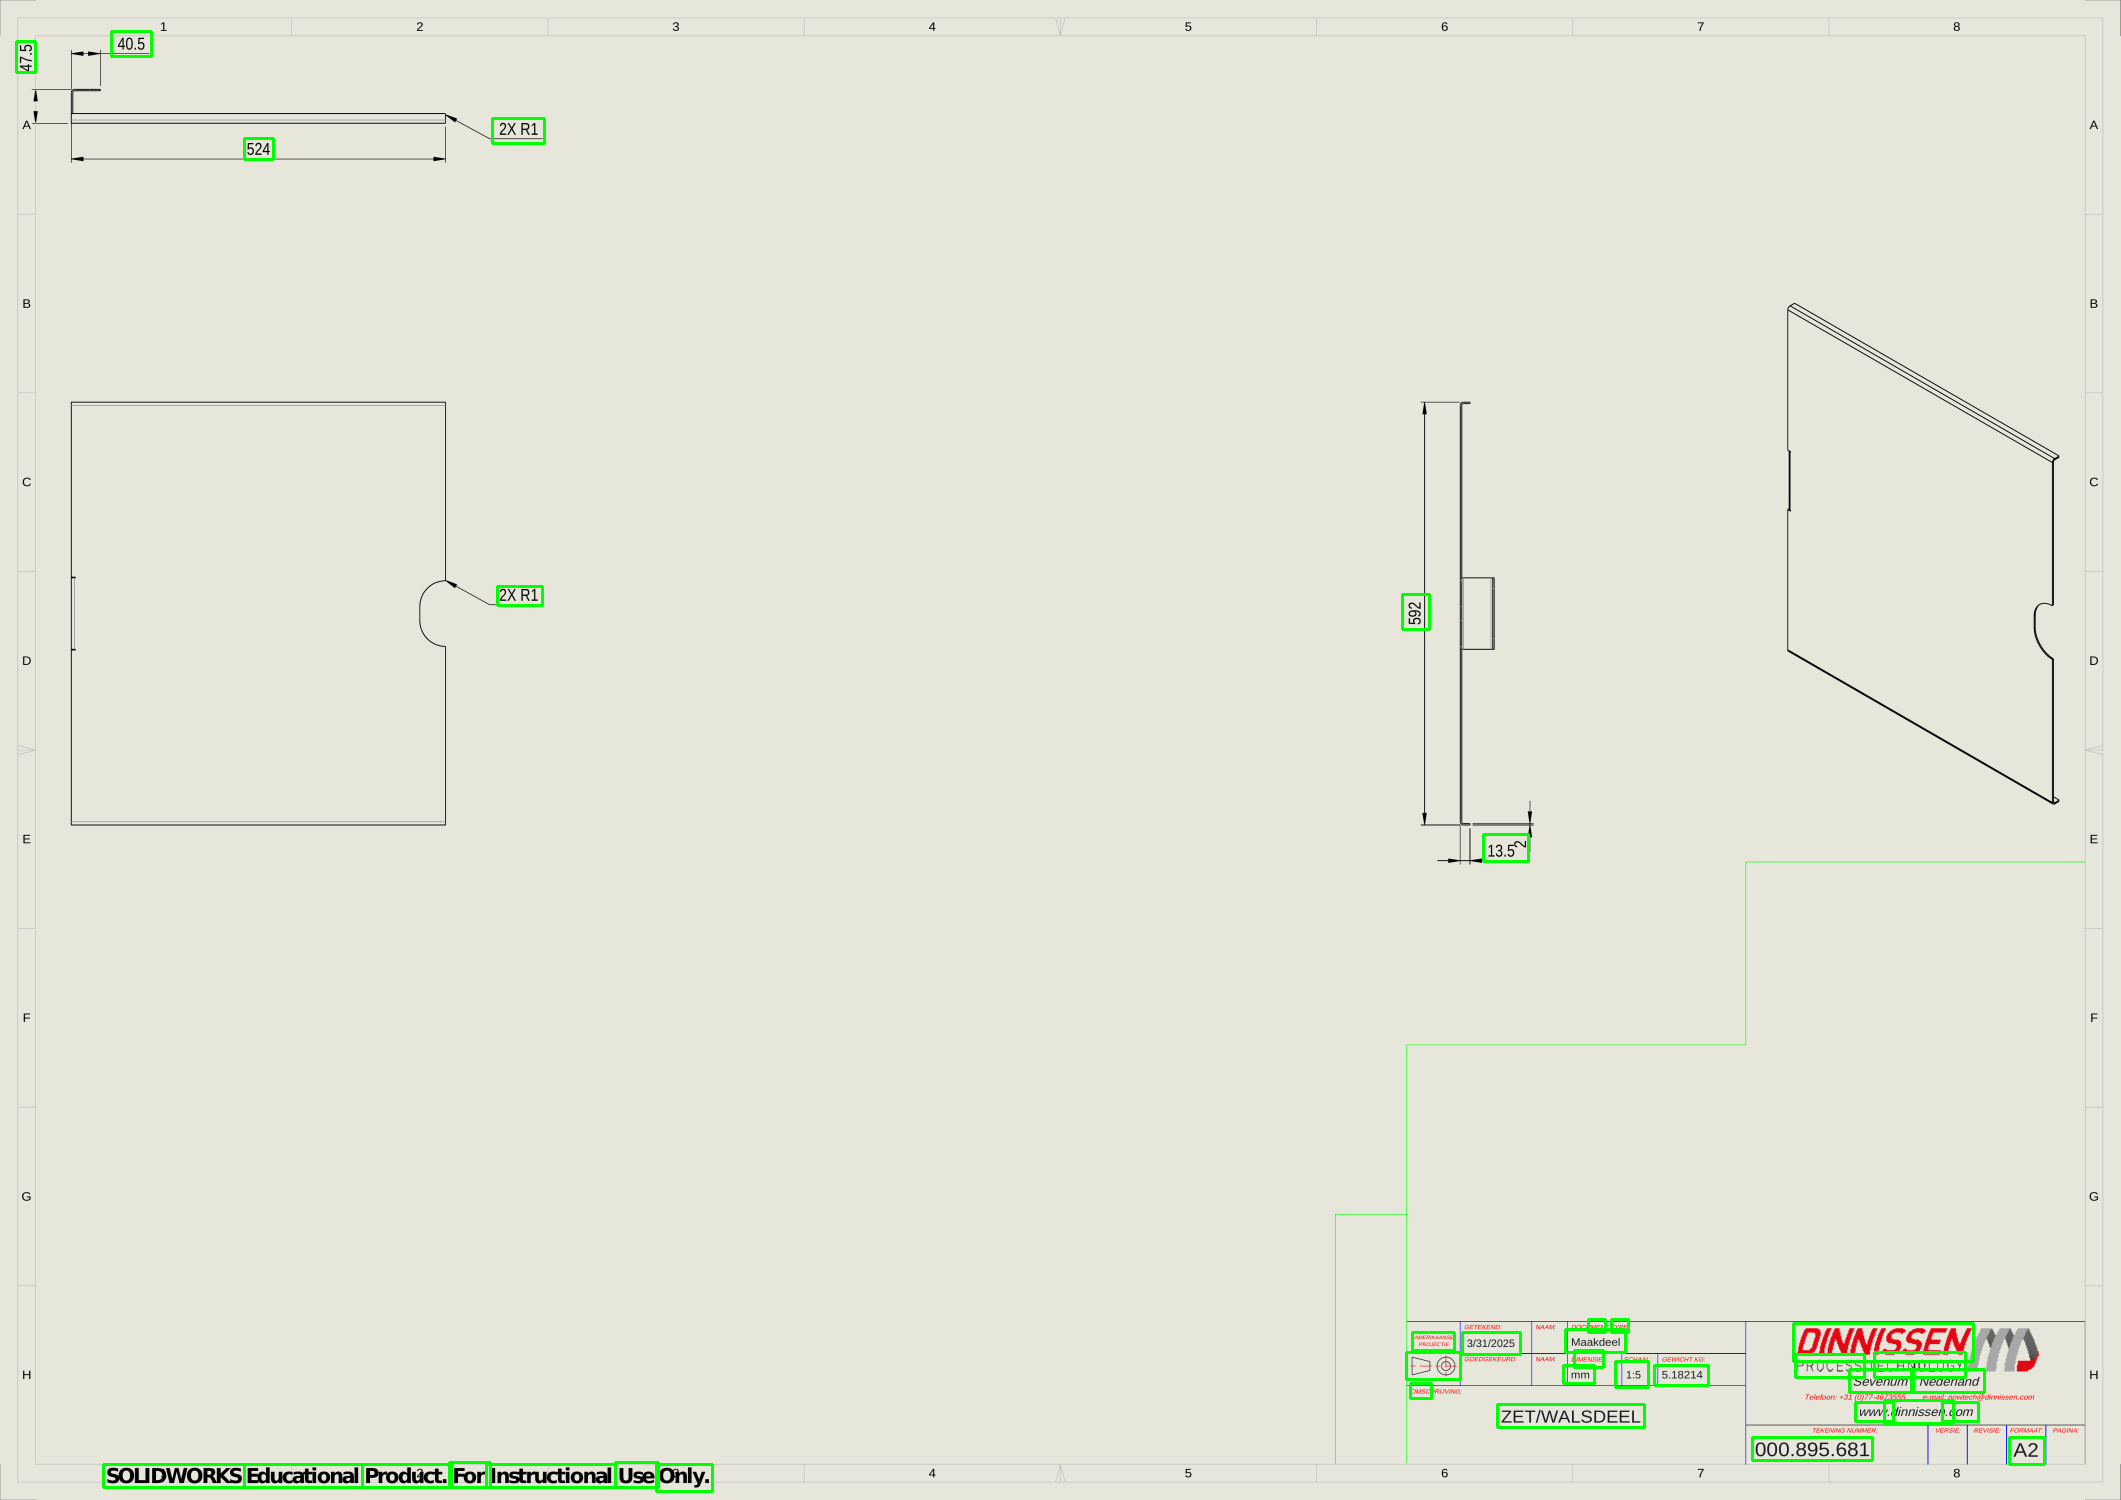

In [5]:
word_boxes = words[["x1", "y1", "x2", "y2"]].loc[height < 50.0].astype(int).values

img_comp = img.copy()

for rect in word_boxes:
    x1, y1, x2, y2 = rect
    cv2.rectangle(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)

Image.fromarray(img_comp)

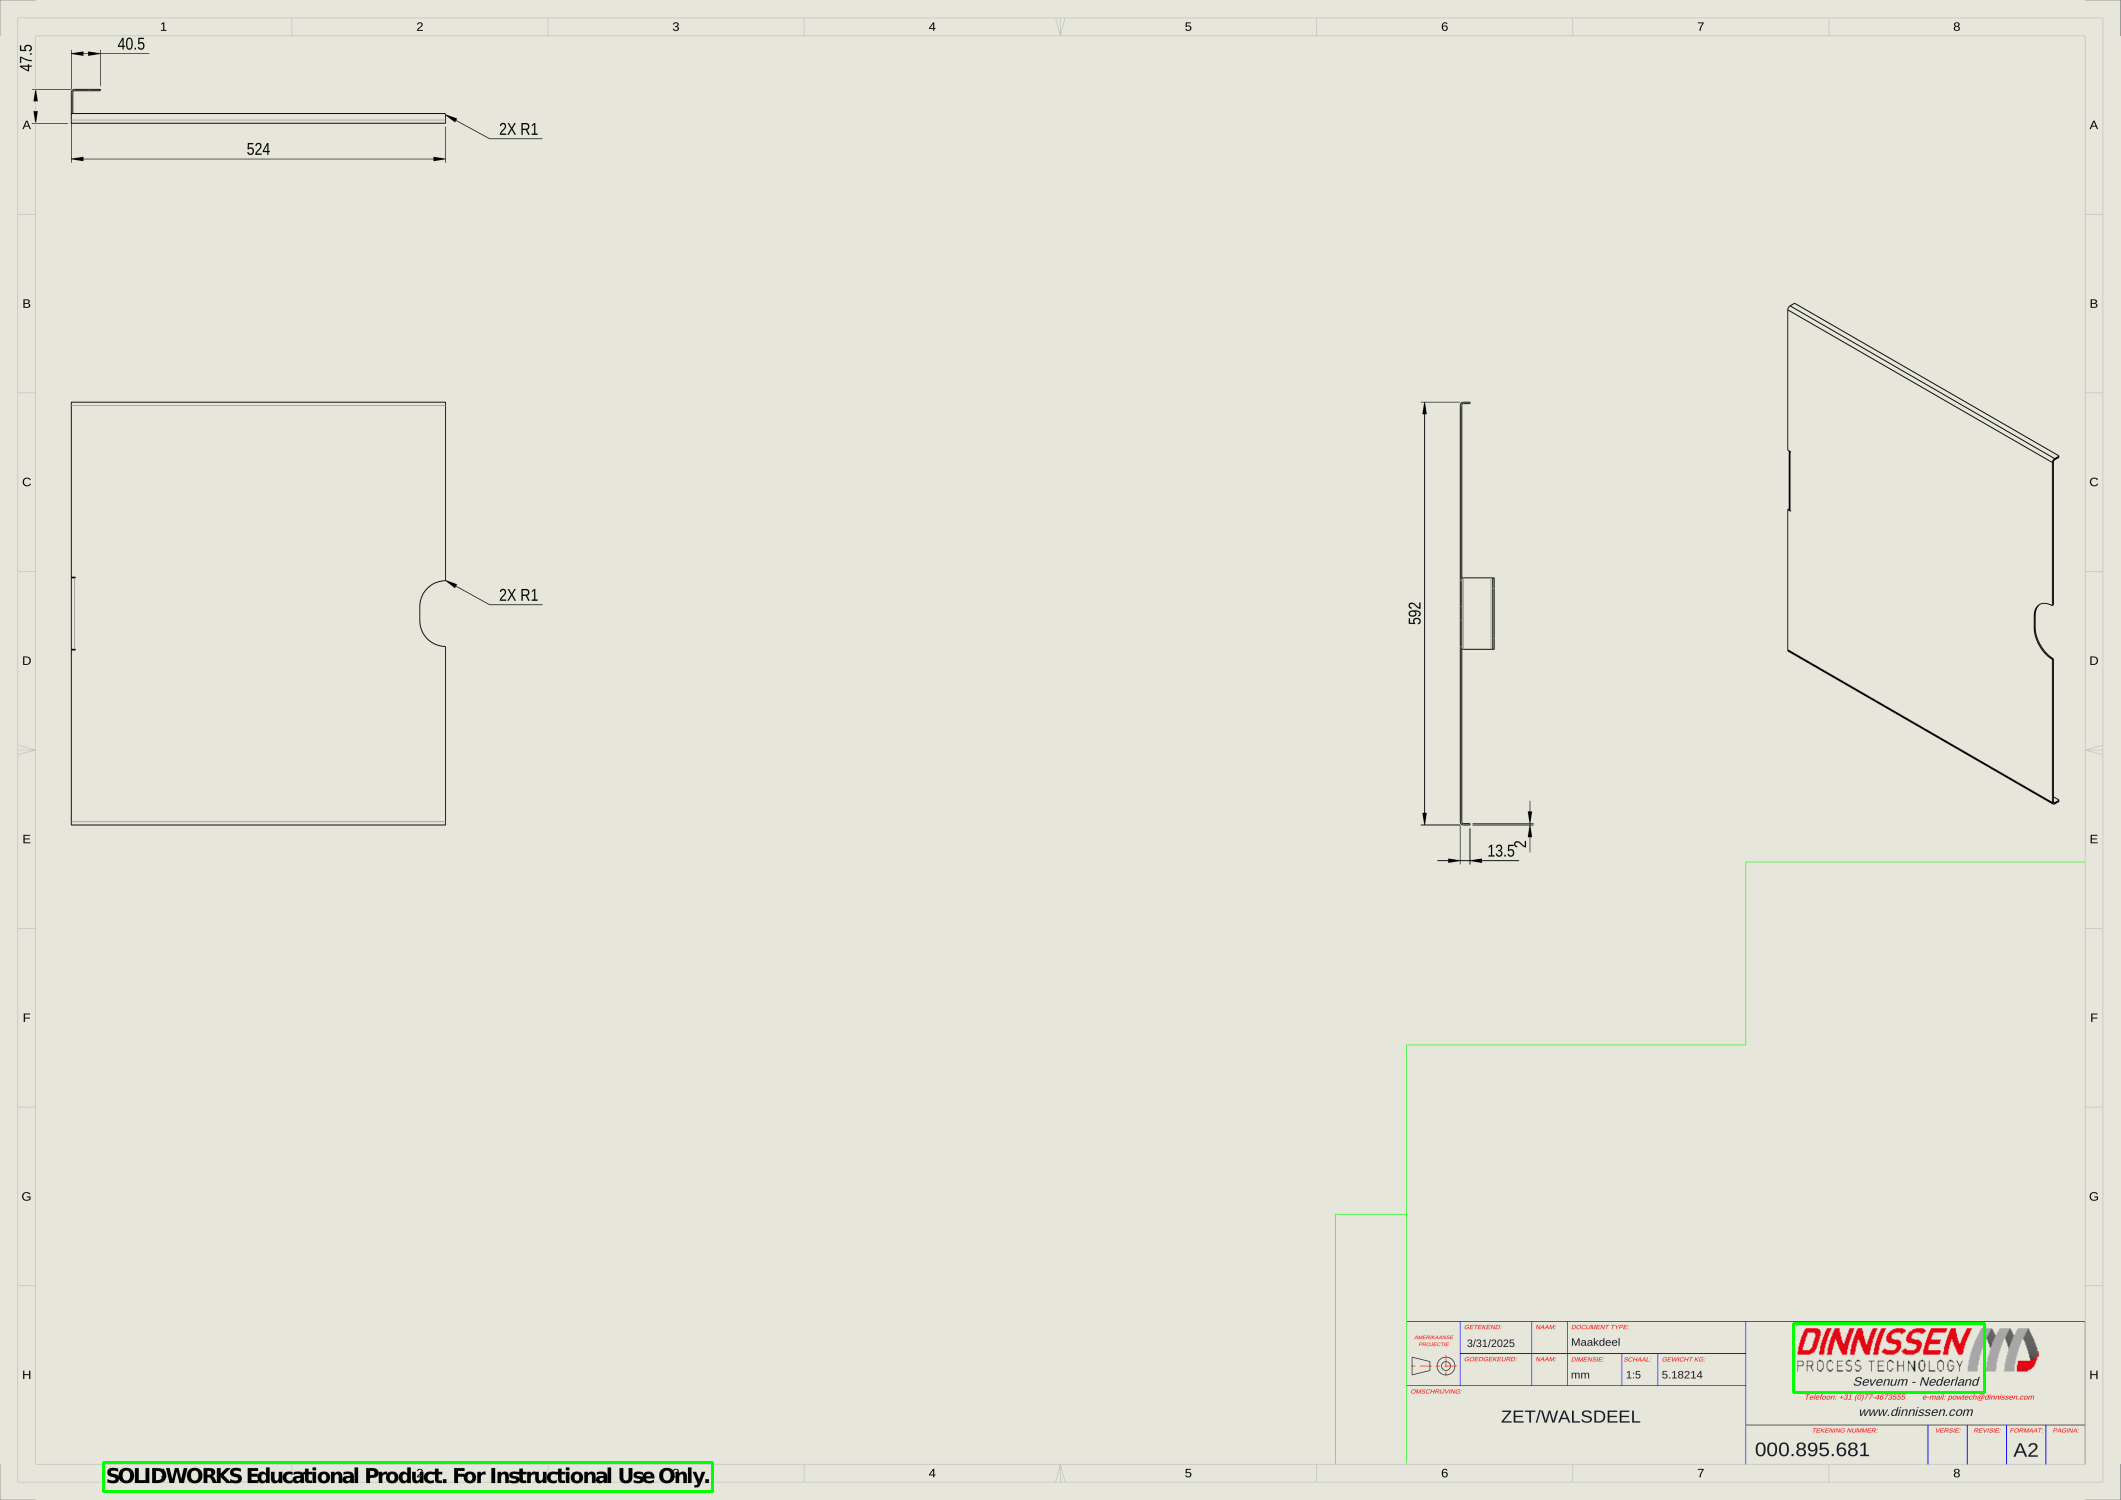

In [6]:
from shapely import unary_union

word_boxes = words[["x1", "y1", "x2", "y2"]].loc[height < 50.0].astype(int).values
# word_boxes = words[["x1", "y1", "x2", "y2"]].astype(int).values

boxes = [
    box(x1, y1, x2, y2)
    for x1, y1, x2, y2 in word_boxes
    if abs(x2 - x1) > 0 and abs(y2 - y1) > 0
]
merged = unary_union(boxes)

if merged.geom_type == 'Polygon':
    merged = [merged]
elif merged.geom_type == 'MultiPolygon':
    merged = list(merged.geoms)

merged_rects = [b.bounds for b in merged]
merged_rects_sorted = sorted(merged_rects, key=lambda r: (r[0], r[1]))

img_copy = img.copy()
for rect in merged_rects_sorted:
    x1, y1, x2, y2 = map(int, rect)
    w, h = abs(x1 - x2), abs(y1 - y2)
    if w * h > 5000:
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

Image.fromarray(img_copy)

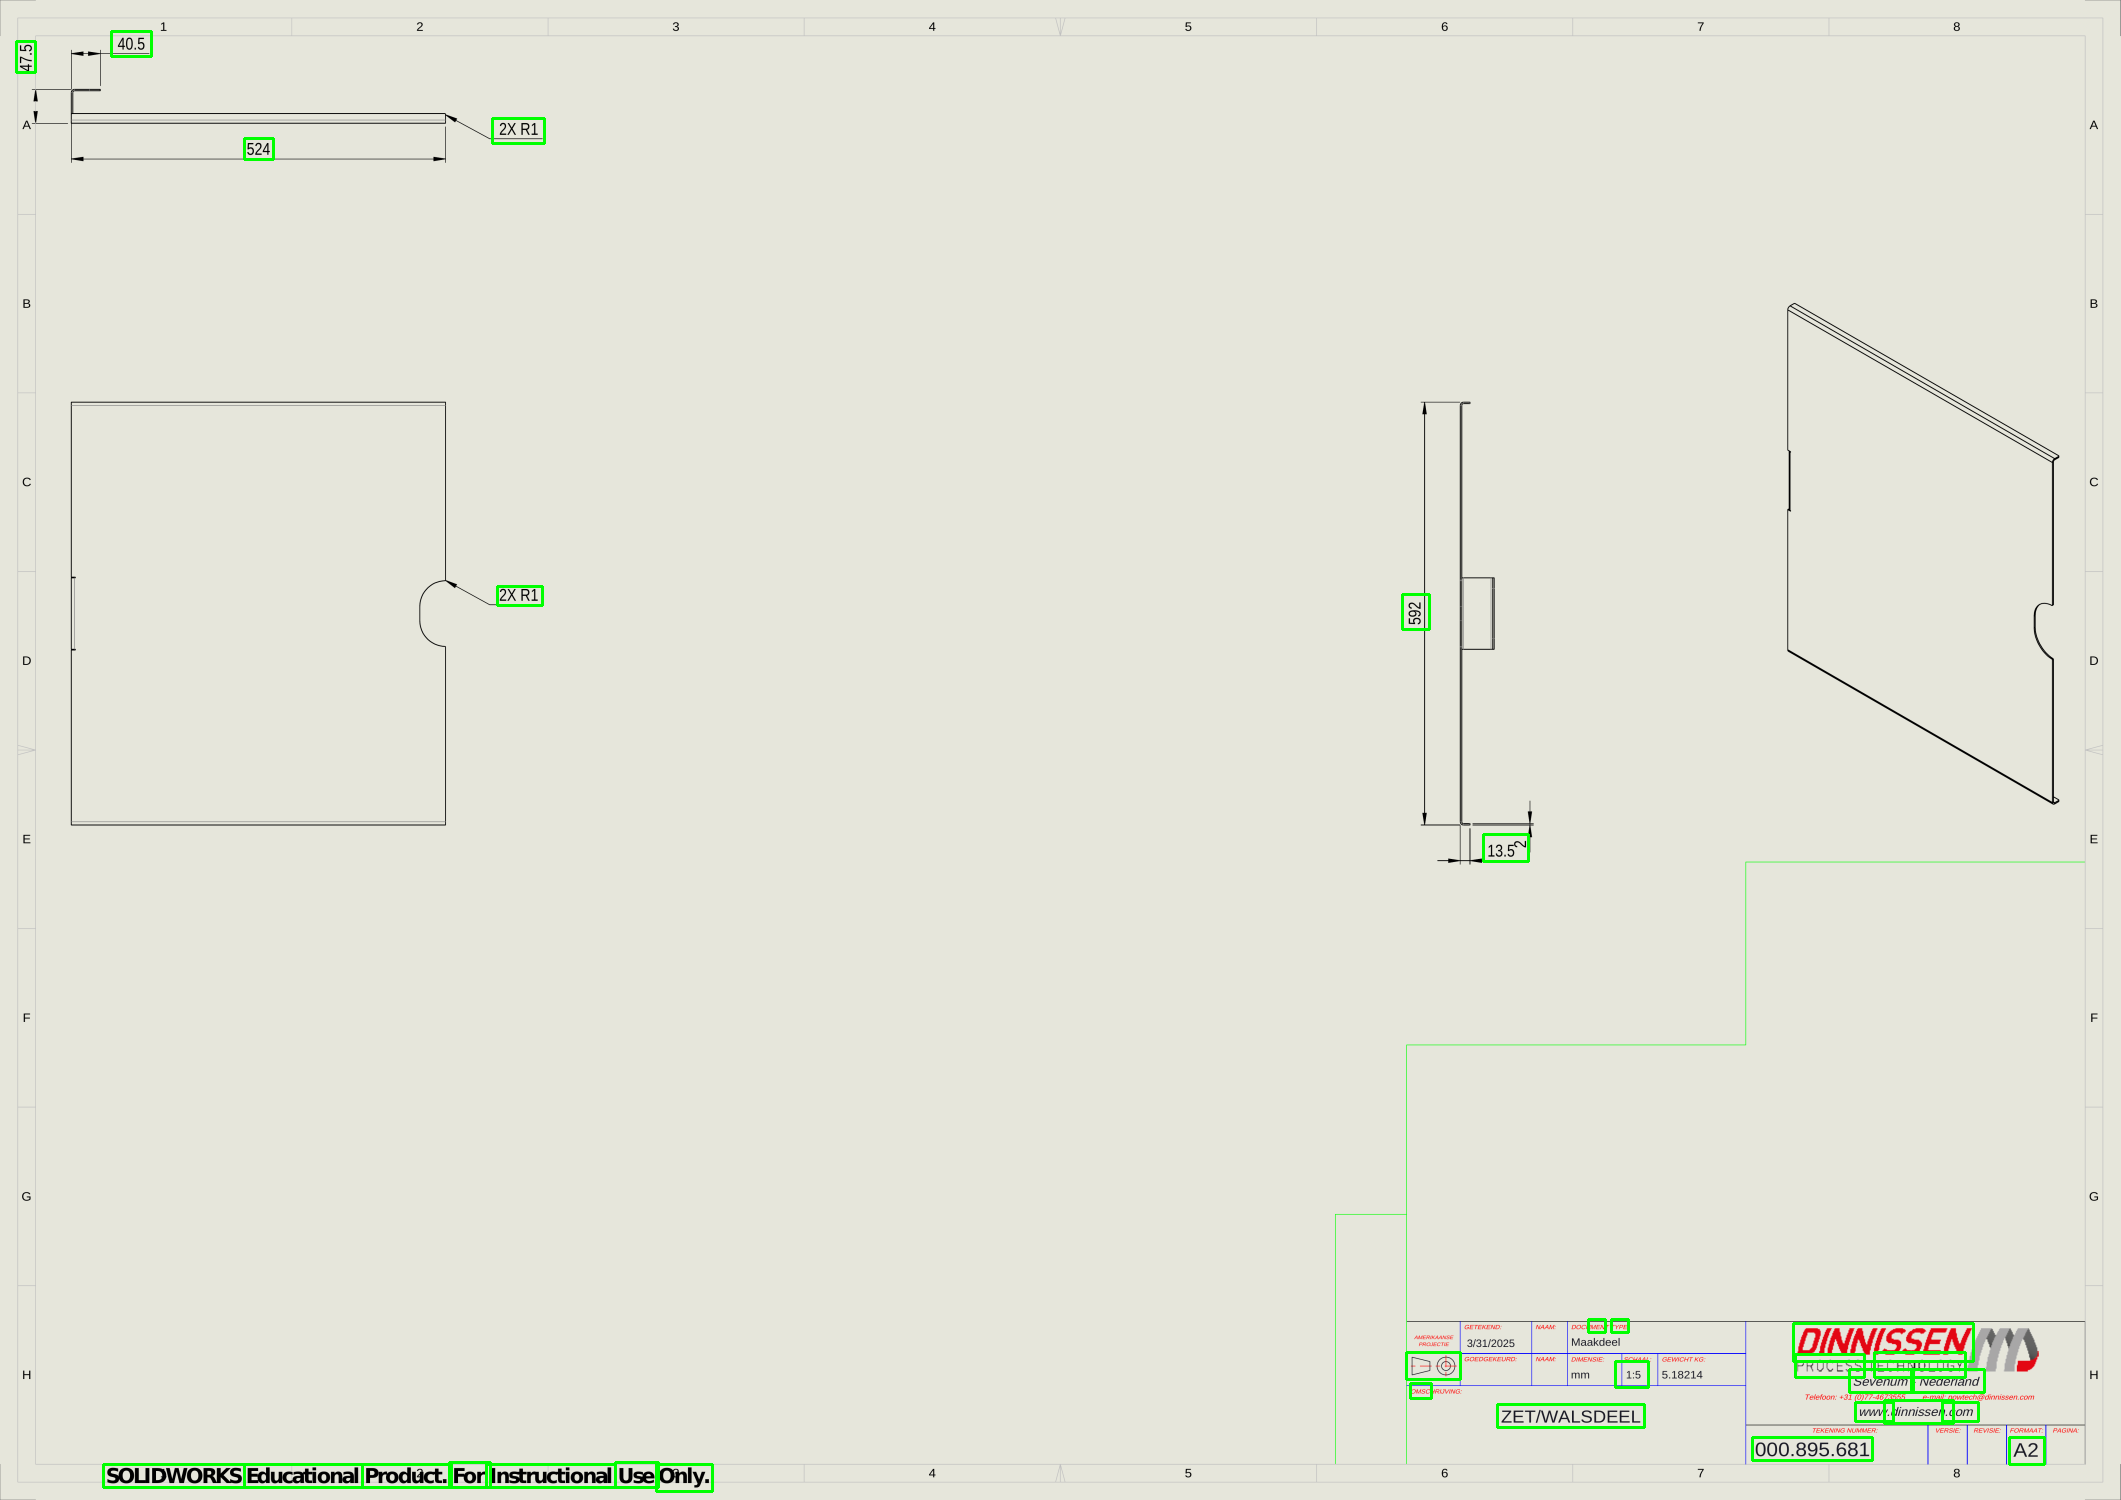

In [7]:
filter_boxes = [box(min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)) for x1, y1, x2, y2 in np.array(tables)]

filtered_array2 = []
for x1, y1, x2, y2 in word_boxes:
    b = box(min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
    if not any(fb.contains(b) for fb in filter_boxes):
        filtered_array2.append((x1, y1, x2, y2))

img_copy = img.copy()

for rect in filtered_array2:
    x1, y1, x2, y2 = map(int, rect)
    # if abs(x1 - x2) * abs(y1 - y2) > 5000:
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

Image.fromarray(img_copy)

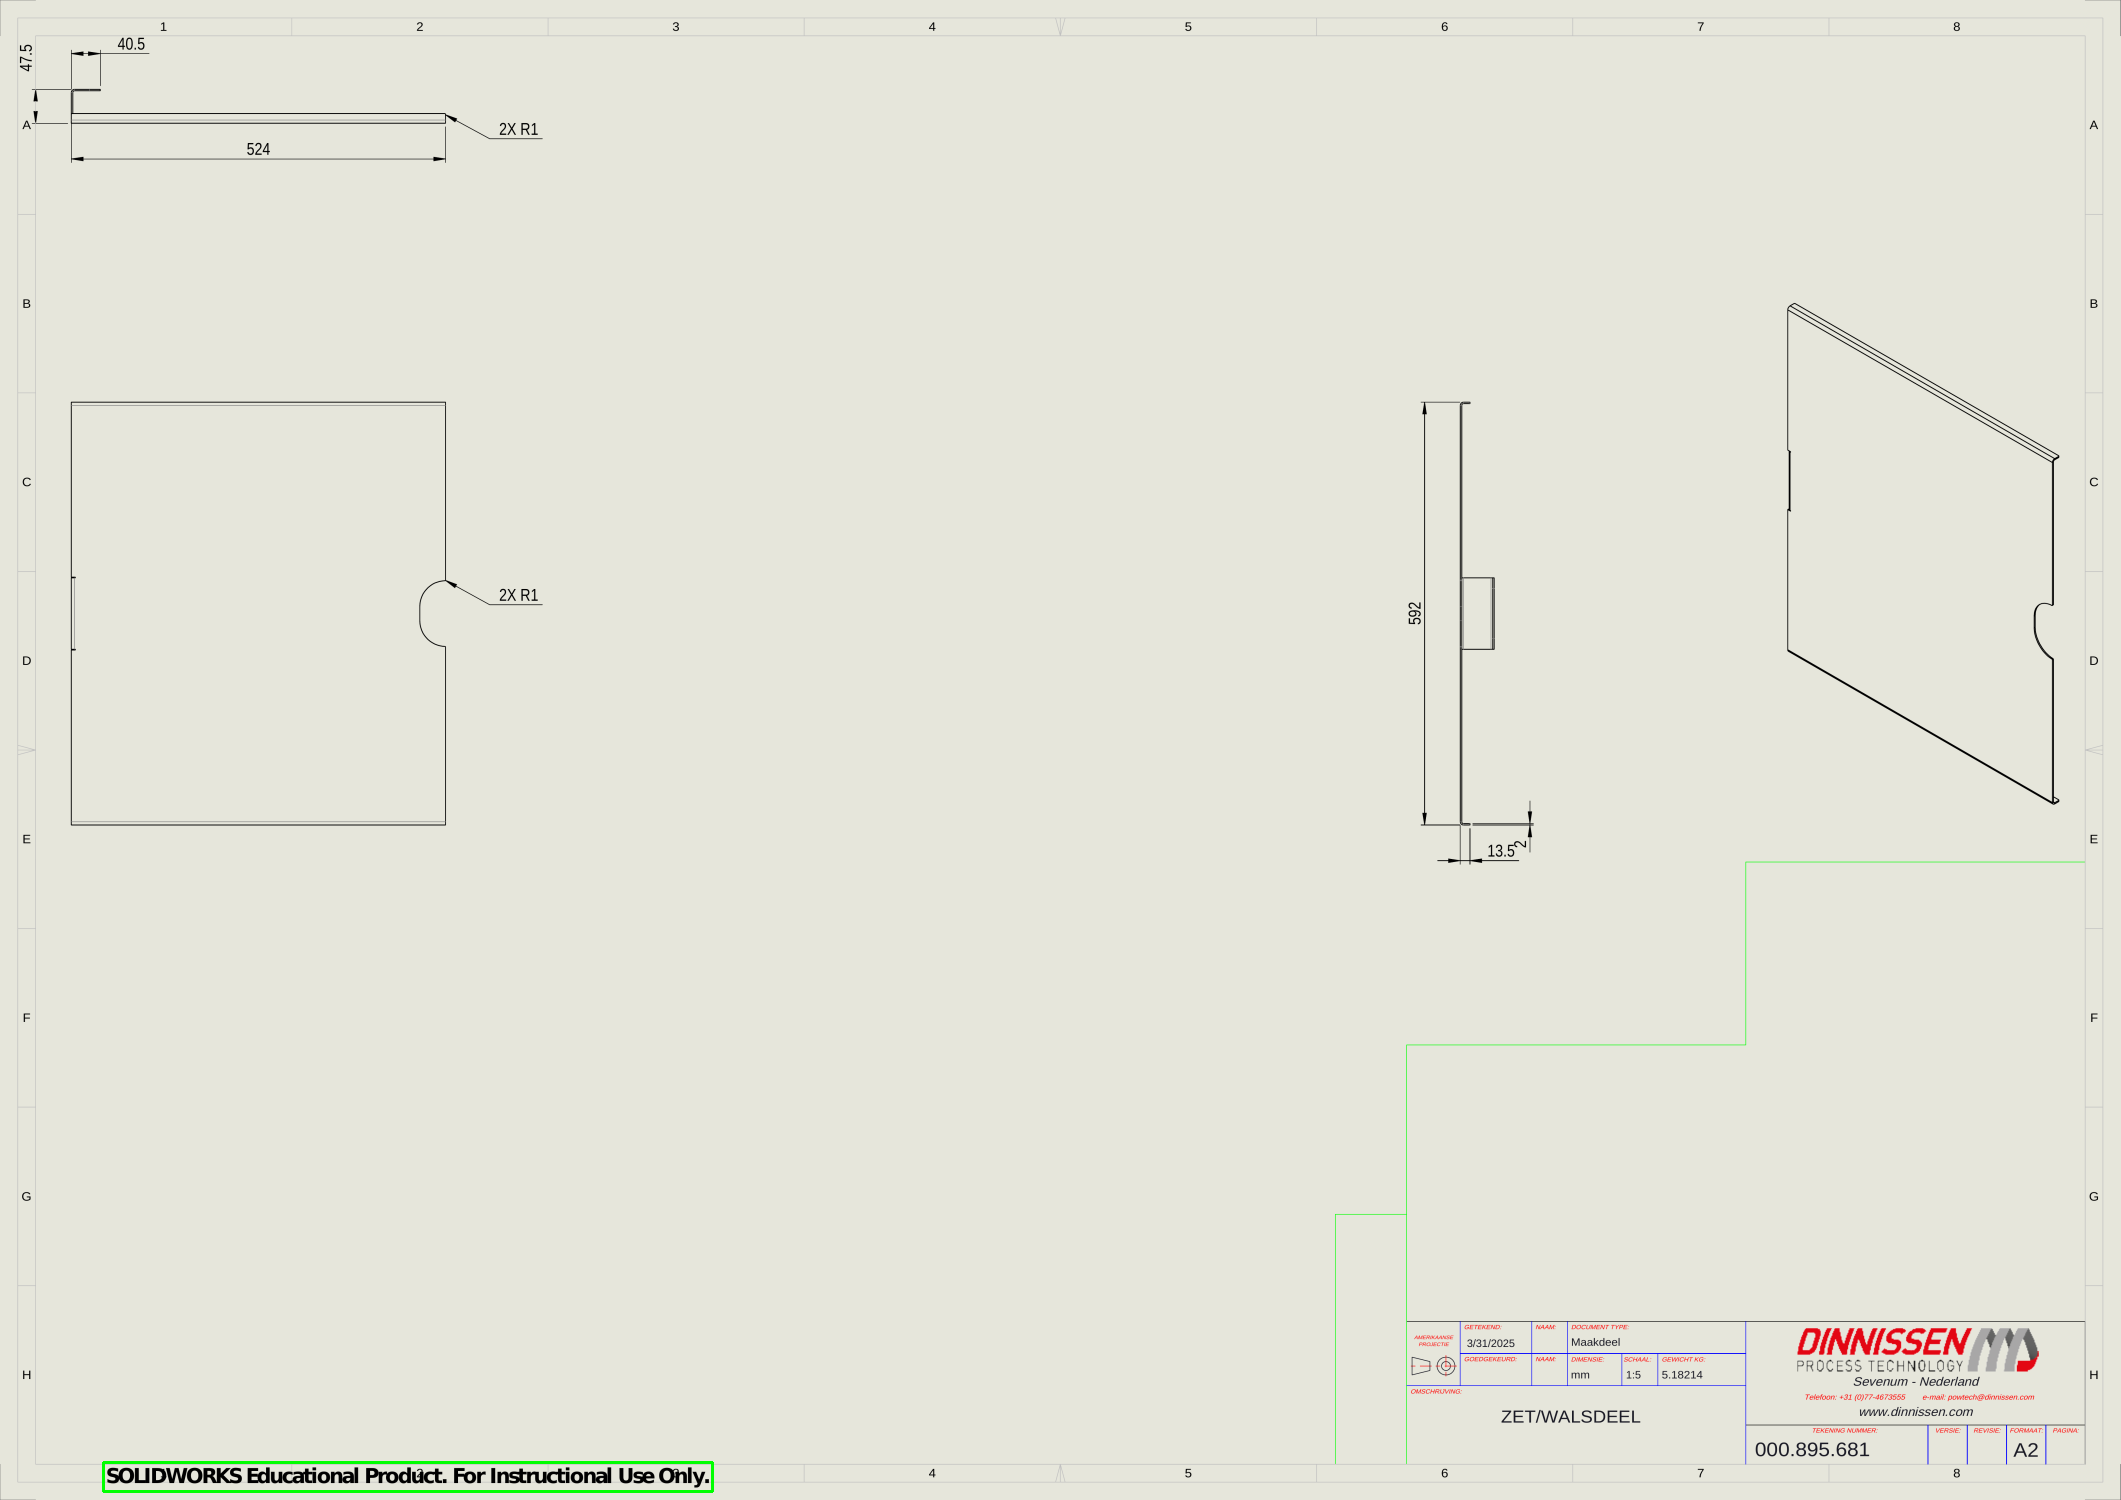

In [8]:
boxes = [
    box(x1, y1, x2, y2)
    for x1, y1, x2, y2 in filtered_array2
    if abs(x2 - x1) > 0 and abs(y2 - y1) > 0
]
merged = unary_union(boxes)

if merged.geom_type == 'Polygon':
    merged = [merged]
elif merged.geom_type == 'MultiPolygon':
    merged = list(merged.geoms)

merged_rects = [b.bounds for b in merged]
merged_rects_sorted = sorted(merged_rects, key=lambda r: (r[0], r[1]))

text_areas = []
img_copy = img.copy()
for rect in merged_rects_sorted:
    x1, y1, x2, y2 = map(int, rect)
    w, h = abs(x1 - x2), abs(y1 - y2)
    if abs(x1 - x2) * abs(y1 - y2) > 5000 and w / float(h) > 4:
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        text_areas.append((x1, y1, x2, y2))

Image.fromarray(img_copy)

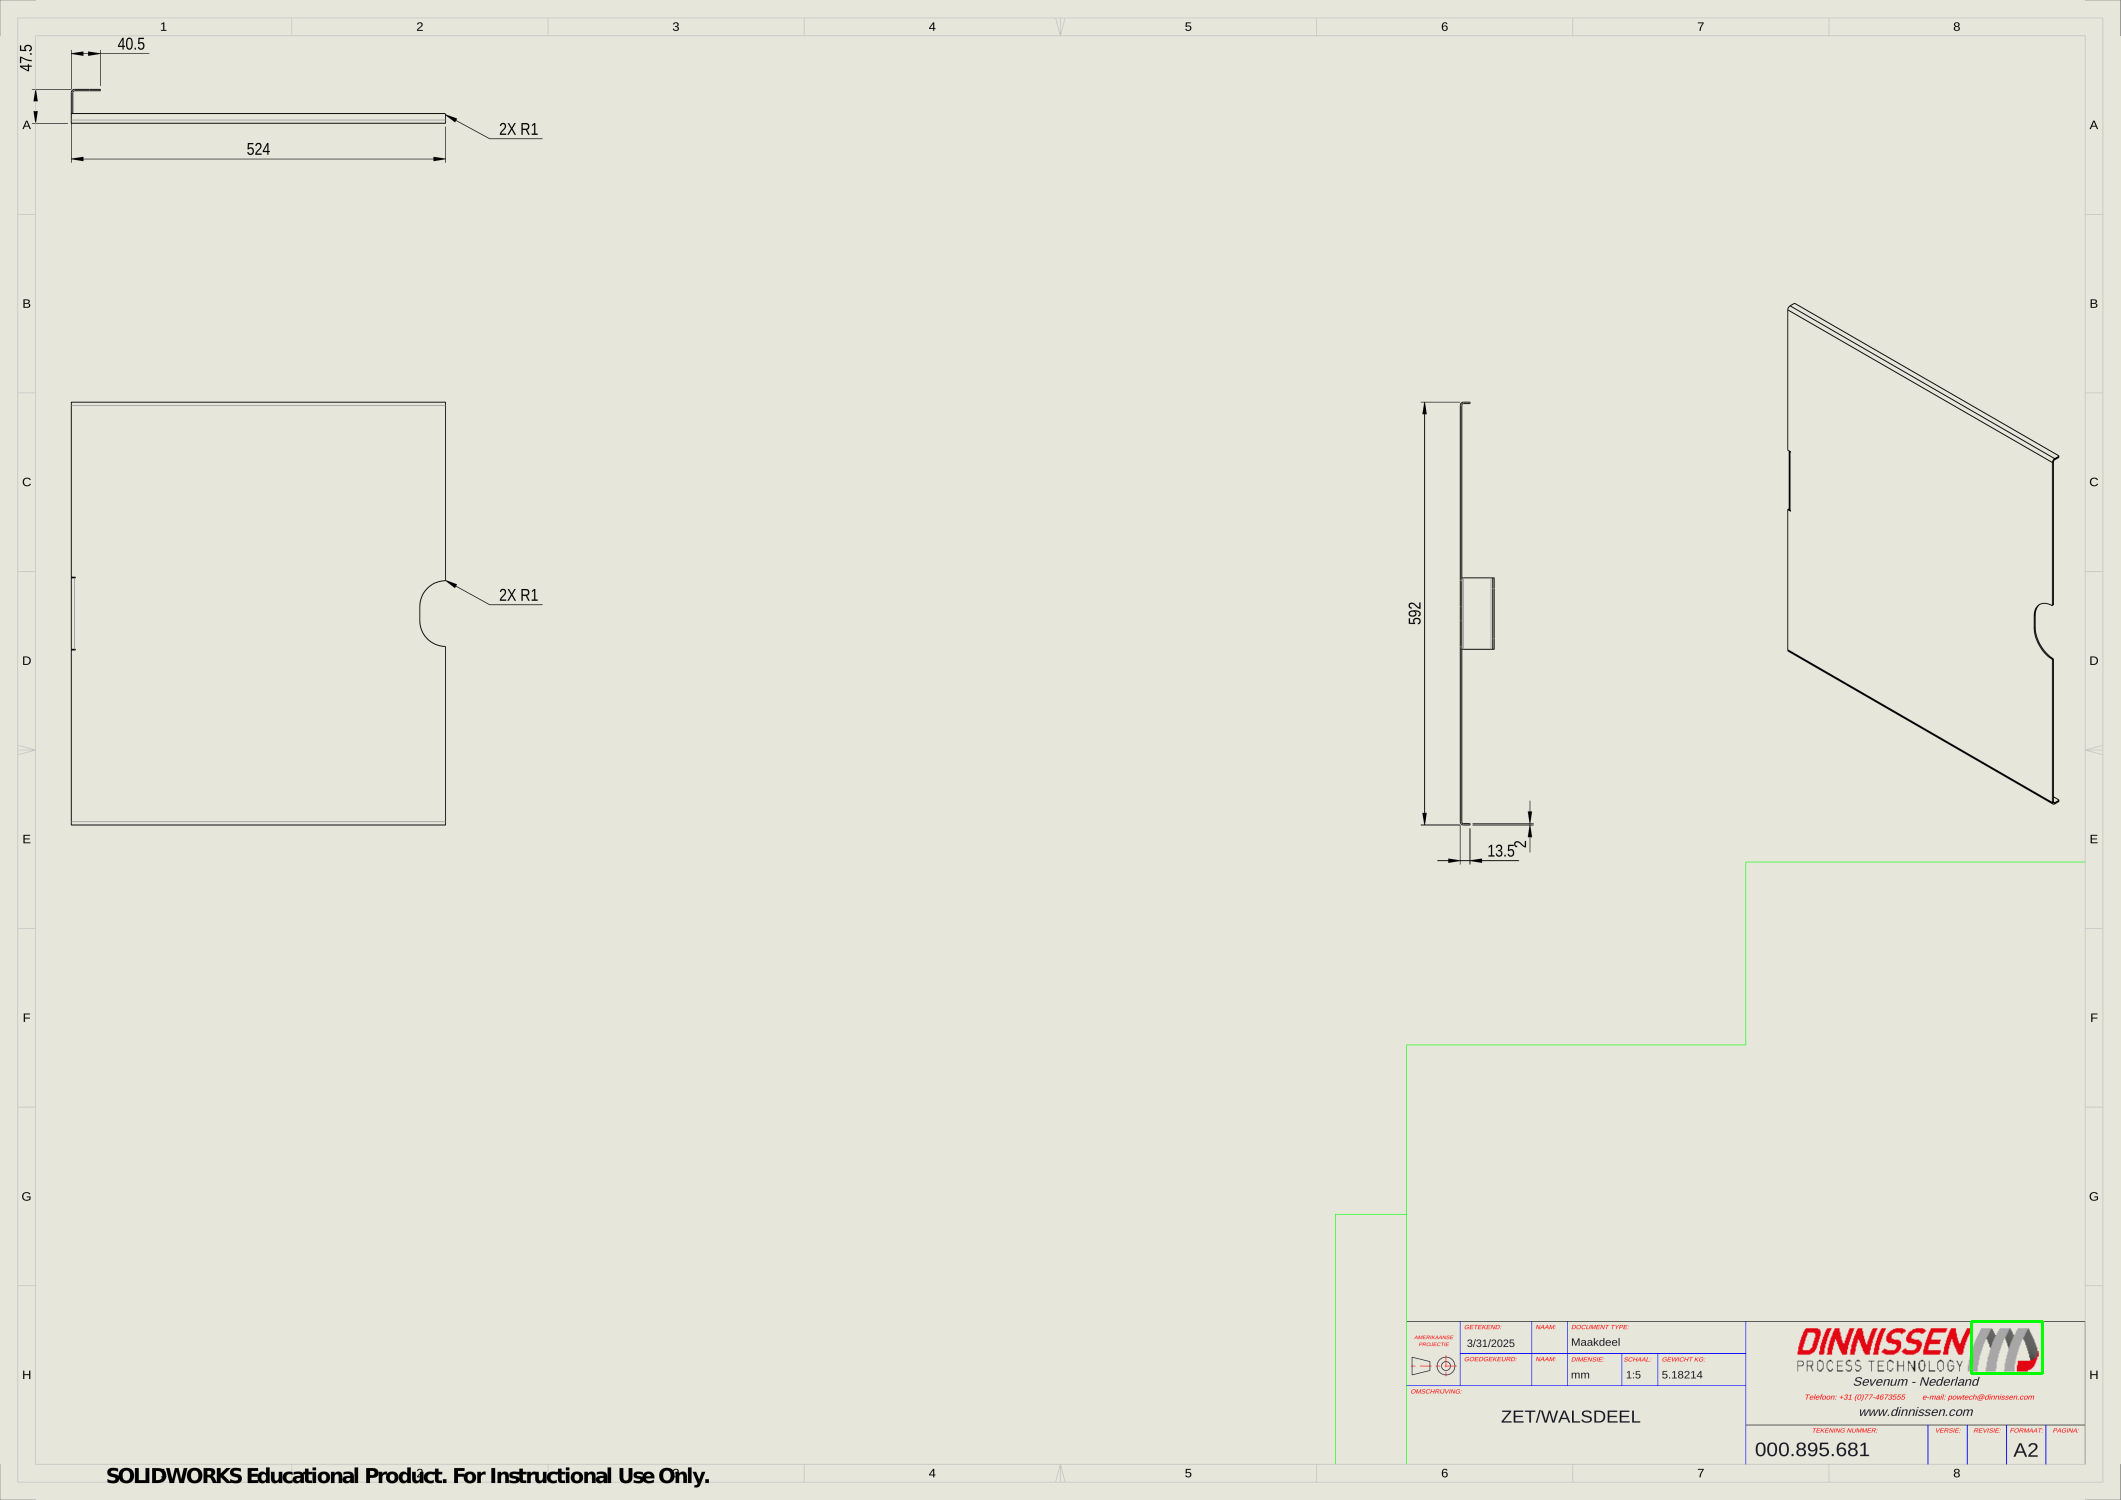

In [9]:
name_boxes = words[["x1", "y1", "x2", "y2"]].loc[height > 50.0].astype(int).values

img_copy = img.copy()
for rect in name_boxes:
    x1, y1, x2, y2 = rect
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

Image.fromarray(img_copy)

[(103, 1462, 712, 1491)] [[1407 1322 1745 1385]
 [1532 1322 1746 1354]] [[1971 1321 2042 1373]]
(4, 4)


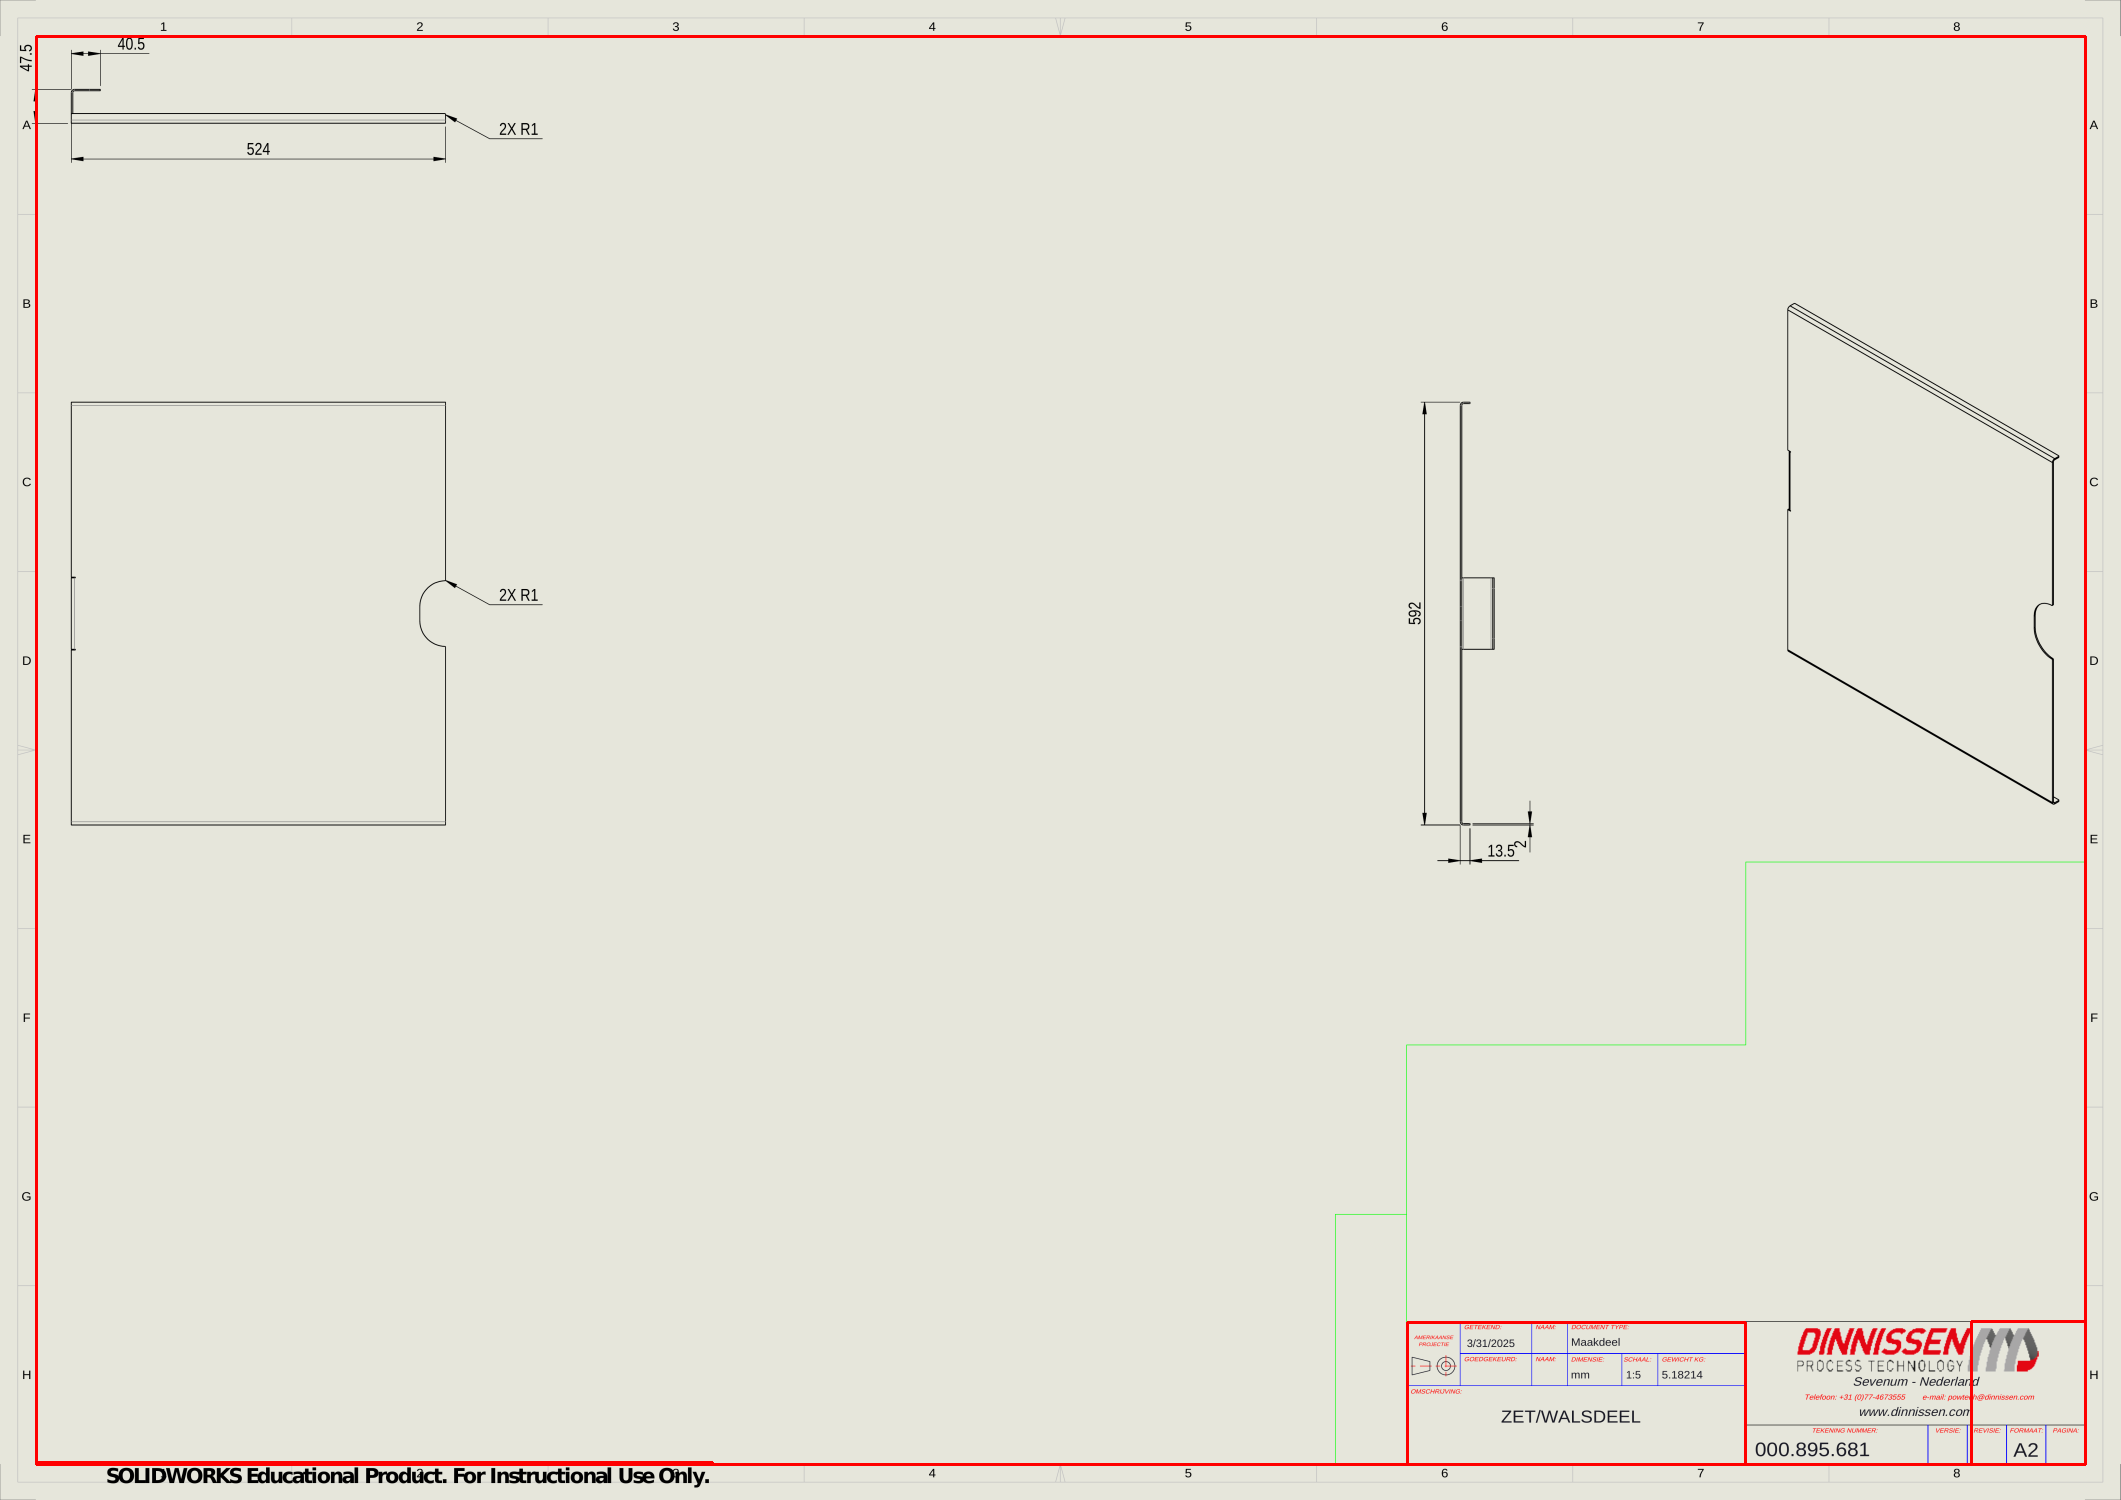

In [10]:
print(text_areas, tables, name_boxes)
template_area = np.zeros((0, 4))
for t in (text_areas, tables, name_boxes):
    if len(t) > 0:
        template_area = np.vstack((template_area, t))

print(template_area.shape)
(x1, y1), (x2, y2) = boundary
left = min(x1, x2)
right = max(x1, x2)
top = min(y1, y2)
bottom = max(y1, y2)
tolerance = 100

tight_boxes = []
for rect in template_area:
    x1, y1, x2, y2 = rect.astype(int)
    w, h = abs(x1 - x2), abs(y1 - y2)

    if w * h > 1000:
        x_min = min(x1, x2)
        x_max = max(x1, x2)
        y_min = min(y1, y2)
        y_max = max(y1, y2)
        side_value_change = []
        if y_min < top + tolerance:
            y_min = top
            side_value_change.append(1)
        if x_min < left + tolerance:
            x_min = left
            side_value_change.append(1)
        if x_max > right - tolerance:
            x_max = right
            side_value_change.append(1)
        if y_max > bottom - tolerance:
            y_max = bottom
            side_value_change.append(1)
        if sum(side_value_change) > 0:
            tight_boxes.append((x_min, y_min, x_max, y_max))


img_copy = img.copy()
cv2.rectangle(img_copy, boundary[0], boundary[1], color, thickness)

for tight_box in tight_boxes:
    cv2.rectangle(img_copy, tight_box[:2], tight_box[2:], (255, 0, 0), 2)

Image.fromarray(img_copy)

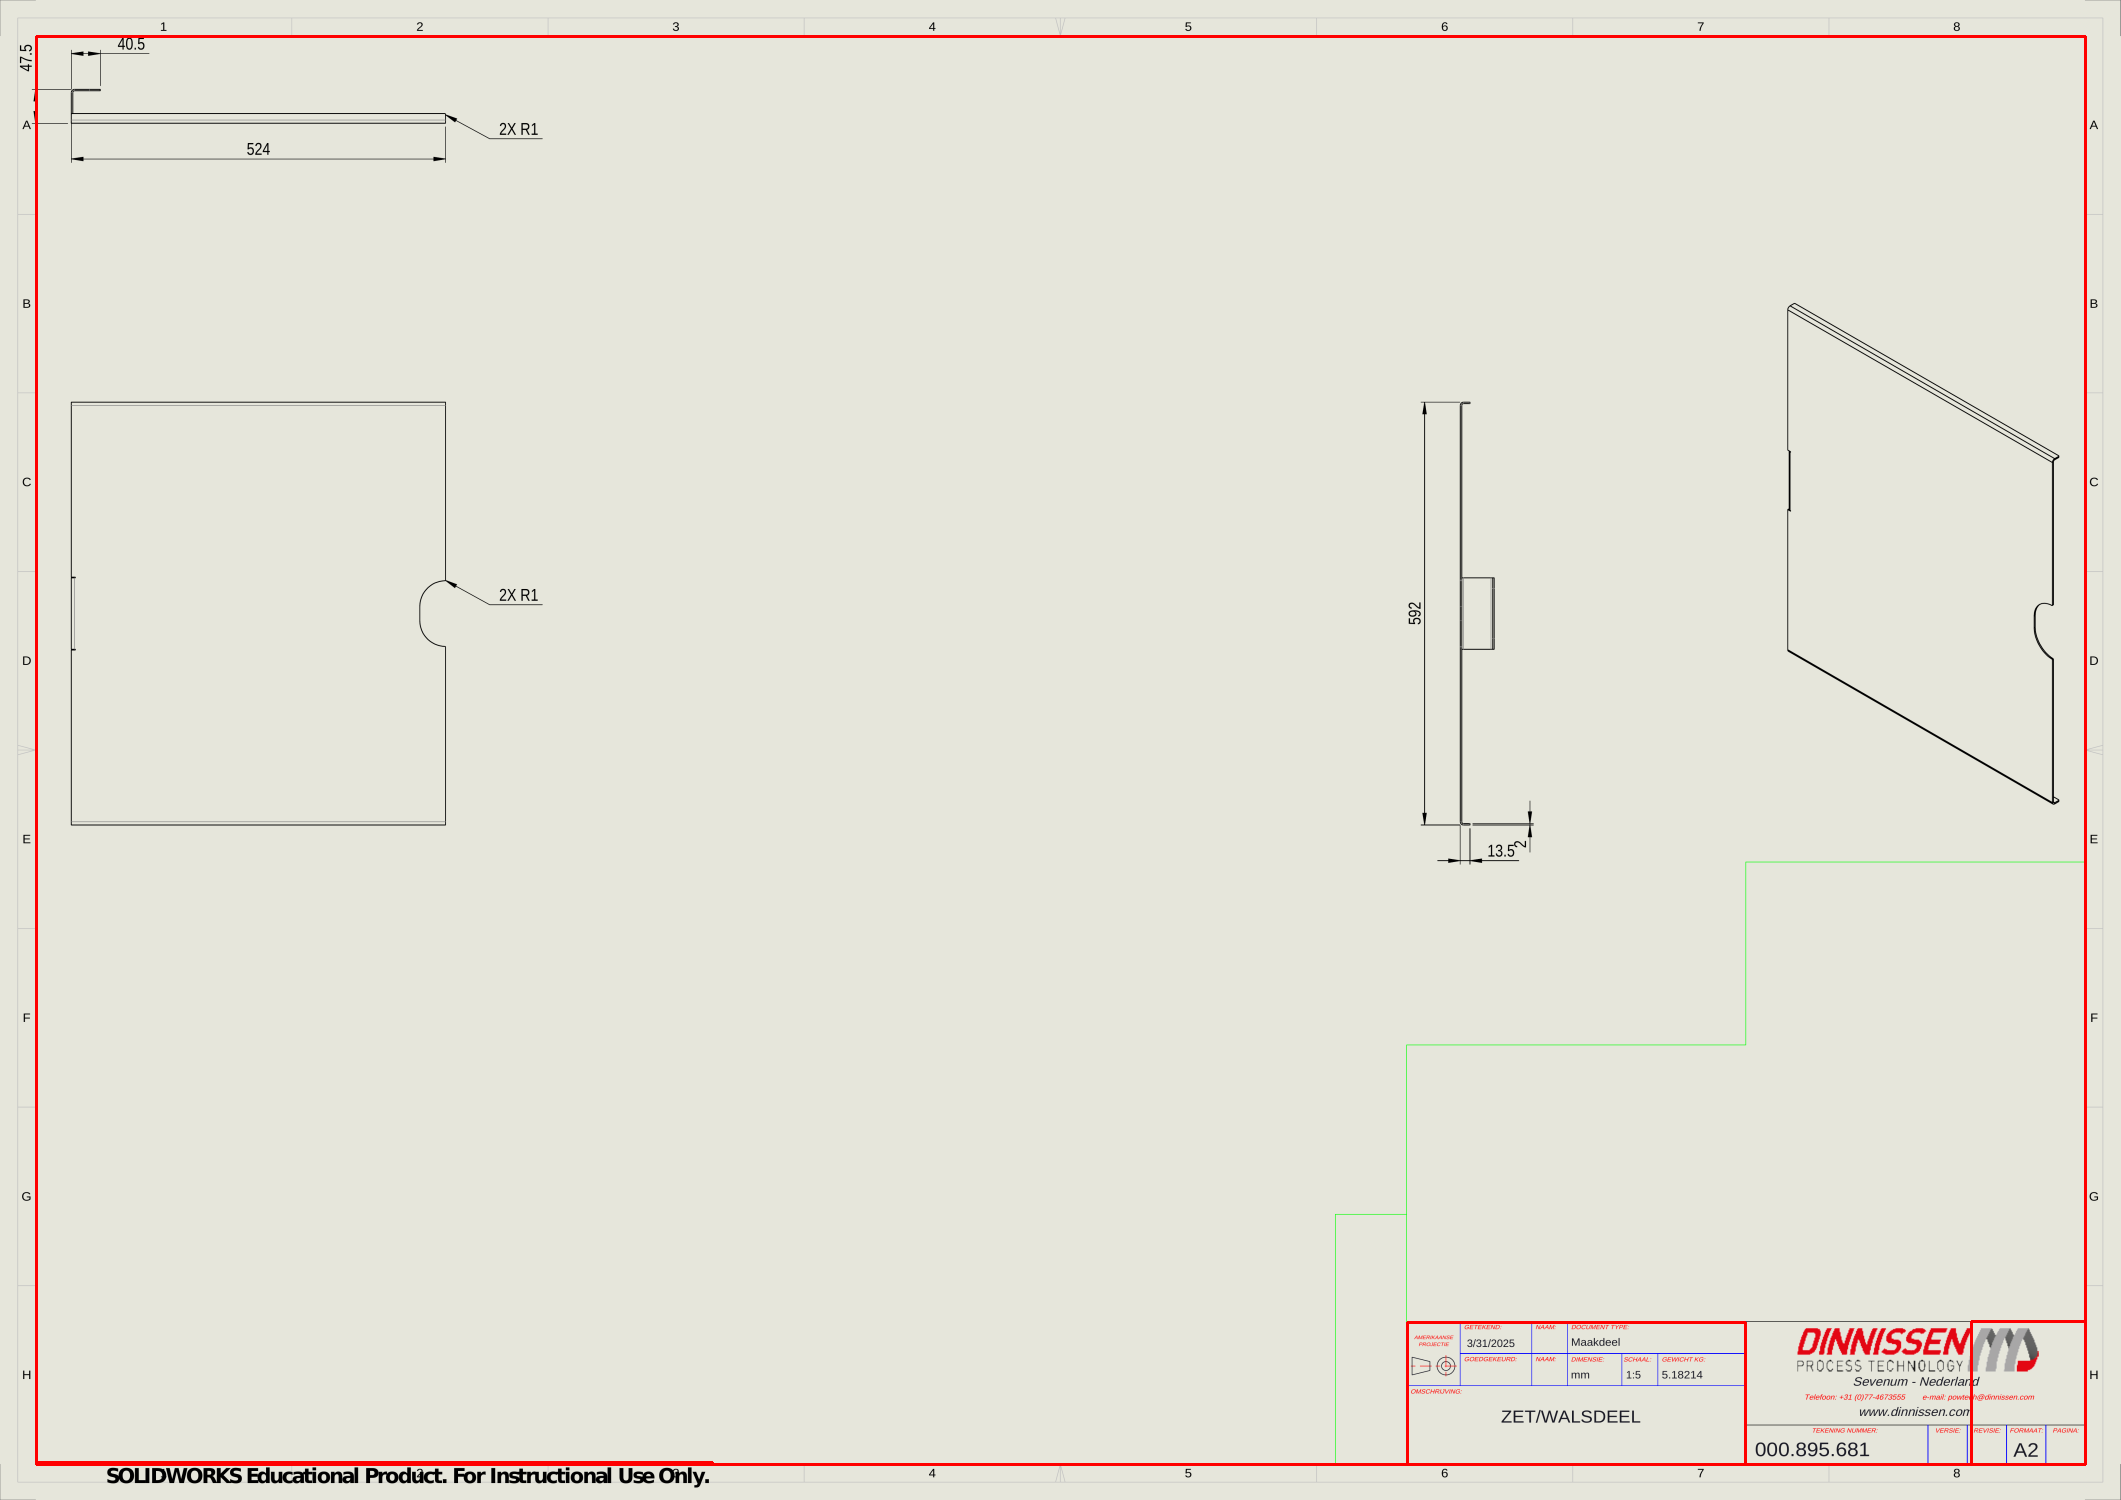

In [11]:
boxes = [box(min(x1,x2), min(y1,y2), max(x1,x2), max(y1,y2)) for x1, y1, x2, y2 in tight_boxes]

filtered = []
for i, b1 in enumerate(boxes):
    if not any(b2.contains(b1) for j, b2 in enumerate(boxes) if i != j):
        filtered.append(tight_boxes[i])

img_copy = img.copy()
cv2.rectangle(img_copy, boundary[0], boundary[1], color, thickness)

border_lines = []
for tight_box in filtered:
    x1, y1, x2, y2 = tight_box

    left = min(x1, x2)
    right = max(x1, x2)
    top = min(y1, y2)
    bottom = max(y1, y2)
    border_lines.extend([
        [left, top, right, top],  # Top
        [left, bottom, left, top],  # Left
        [right, bottom, right, top],  # Right
        [left, bottom, right, bottom],  # Bottom
    ])

border_lines = np.array(border_lines)
for border_line in border_lines:
    cv2.line(img_copy, border_line[:2], border_line[2:], (255, 0, 0), 2)

Image.fromarray(img_copy)